In [1]:
#%pip install protobuf-compiler
#%pip install protobuf==3.20.*
#%pip install tensorflow_hub
#%pip install --upgrade tensorflow-estimator==2.3.0
#%pip install --force-reinstall tensorflow


import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
import tempfile
from PIL import Image, ImageOps



def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    return resized_temp_filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    detections = {key: value.numpy() if isinstance(value, tf.Tensor) else value for key, value in result.items()}

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    return image_with_boxes, detections

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)



In [2]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']

food = np.array( [[r"\bApple\b",14,0.52,0.78],
                  [r"\bBanana\b",439,0.89,0.91],
                  [r"\bGrape\b",223,0.69,0.97],
                  [r"\bLemon\b",435,0.29,0.96],
                  [r"\bMango\b",513,0.60,1.07],
                  [r"\bOrange\b",481,0.63,0.90],
                  [r"\bPeach\b",492,0.57,0.96],
                  [r"\bPear\b",341,0.39,1.02]])

#coin: 132
#plate: 312

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
import cv2

def run_grabcut(image_path, detections, food_index):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== int(food[food_index][1]):
            mask = np.zeros((height, width), np.uint8)

            mask[ymin:ymax, xmin:xmax] = 1

            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)

            cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            segmented_image = image * mask2[:, :, np.newaxis]
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Segmented Image')
            print(ymin, xmin, ymax, xmax)
            plt.show()

            return segmented_image, ymin, xmin, ymax, xmax
  

def coin_pixels(image_path, detections):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== 132:
            return ymin, xmin, ymax, xmax

In [4]:
import re
def process_images(image_path, image_path1):
    
    resized_image_path = resize_image(image_path, 650, 419, True)
    image_with_boxes, detections = run_detector(detector, resized_image_path)
    max_score = max(detections['detection_scores'])
    print(max_score)

    for i in range(len(food)):
        match = re.search(food[i][0], image_path)

        if match:
            food_index = i

    segmented_image_s,ymin_s, xmin_s, ymax_s, xmax_s = run_grabcut(resized_image_path, detections,food_index)
    ymin_cs, xmin_cs, ymax_cs, xmax_cs = coin_pixels(resized_image_path,detections)

    resized_image_path1 = resize_image(image_path1, 650, 419, True)
    image_with_boxes, detections = run_detector(detector, resized_image_path1)
    display_image(image_with_boxes)
    
    segmented_image_t,ymin_t, xmin_t, ymax_t, xmax_t = run_grabcut(resized_image_path1, detections, food_index)
    ymin_ct, xmin_ct, ymax_ct, xmax_ct = coin_pixels(resized_image_path1,detections)

    coin_diameter_mm = 25.0
    coin_diameter_pixel = 94.49 

    top_coin_height_mm = ((ymax_ct - ymin_ct) * coin_diameter_mm)/coin_diameter_pixel
    side_coin_height_mm = ((ymax_cs - ymin_cs) * coin_diameter_mm)/coin_diameter_pixel

    # Calcolo del fattore di conversione da millimetri a pixel
    conversion_factor_top = top_coin_height_mm / (ymax_ct - ymin_ct)
    conversion_factor_side = side_coin_height_mm / (ymax_cs - ymin_cs)
    conversion_factor = coin_diameter_mm /coin_diameter_pixel
    print(conversion_factor_top)
    print(conversion_factor_side)

    top_view_box_width_mm = (xmax_t - xmin_t) * conversion_factor_top 
    top_view_box_height_mm = (ymax_t - ymin_t) * conversion_factor_top 

    side_view_box_width_mm = (xmax_s - xmin_s) * conversion_factor_side
    side_view_box_height_mm = (ymax_s - ymin_s) * conversion_factor_side

    volume = (top_view_box_width_mm*side_view_box_height_mm*top_view_box_height_mm)/1000
    weight= volume * float(food[food_index][3])

    energy = float(food[food_index][2])
    estimated_calories = energy * weight

    print("Estimated dimensions of the food box from the top view (length x height)", top_view_box_width_mm, "mm x", top_view_box_height_mm, "mm")
    print("Estimated dimensions of the food box from the side view (length x height)", side_view_box_width_mm, "mm x", side_view_box_height_mm, "mm")
    print("Estimated weight:", weight, "g")
    print("Estimated volume:", volume, "cm^3")
    print("Estimated calories:", estimated_calories, "calories")
    

    weight_string = "Estimated weight:" + str(weight) + "g\n"
    volume_string = "Estimated volume:" + str(volume) + "cm^3\n"
    calories_string = "Estimated calories:" + str(estimated_calories) + "calories\n"

    return weight_string, volume_string, calories_string

def calculate_pixel_per_unit(coin_diameter_mm, coin_diameter_pixel):
    pixel_per_unit = coin_diameter_pixel / coin_diameter_mm
    return pixel_per_unit

C:\Users\USER\AppData\Local\Temp\ipykernel_11640\2000387561.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img1 = img1.resize((200, 200), Image.ANTIALIAS)
C:\Users\USER\AppData\Local\Temp\ipykernel_11640\2000387561.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img2.resize((200, 200), Image.ANTIALIAS)


Avvio del processo...
Found 100 objects.
Inference time:  17.545975923538208
Font not found, using default font.
0.99398685
9 211 252 464


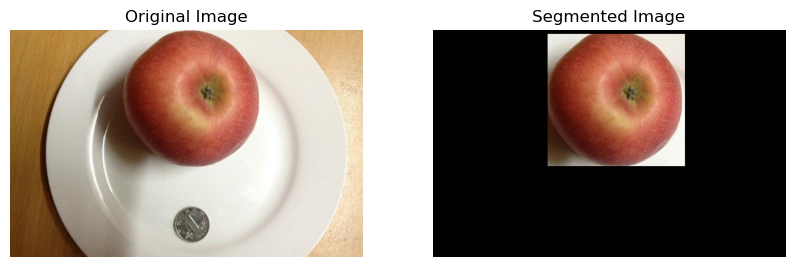

Found 100 objects.
Inference time:  20.36410903930664
Font not found, using default font.
80 286 397 598


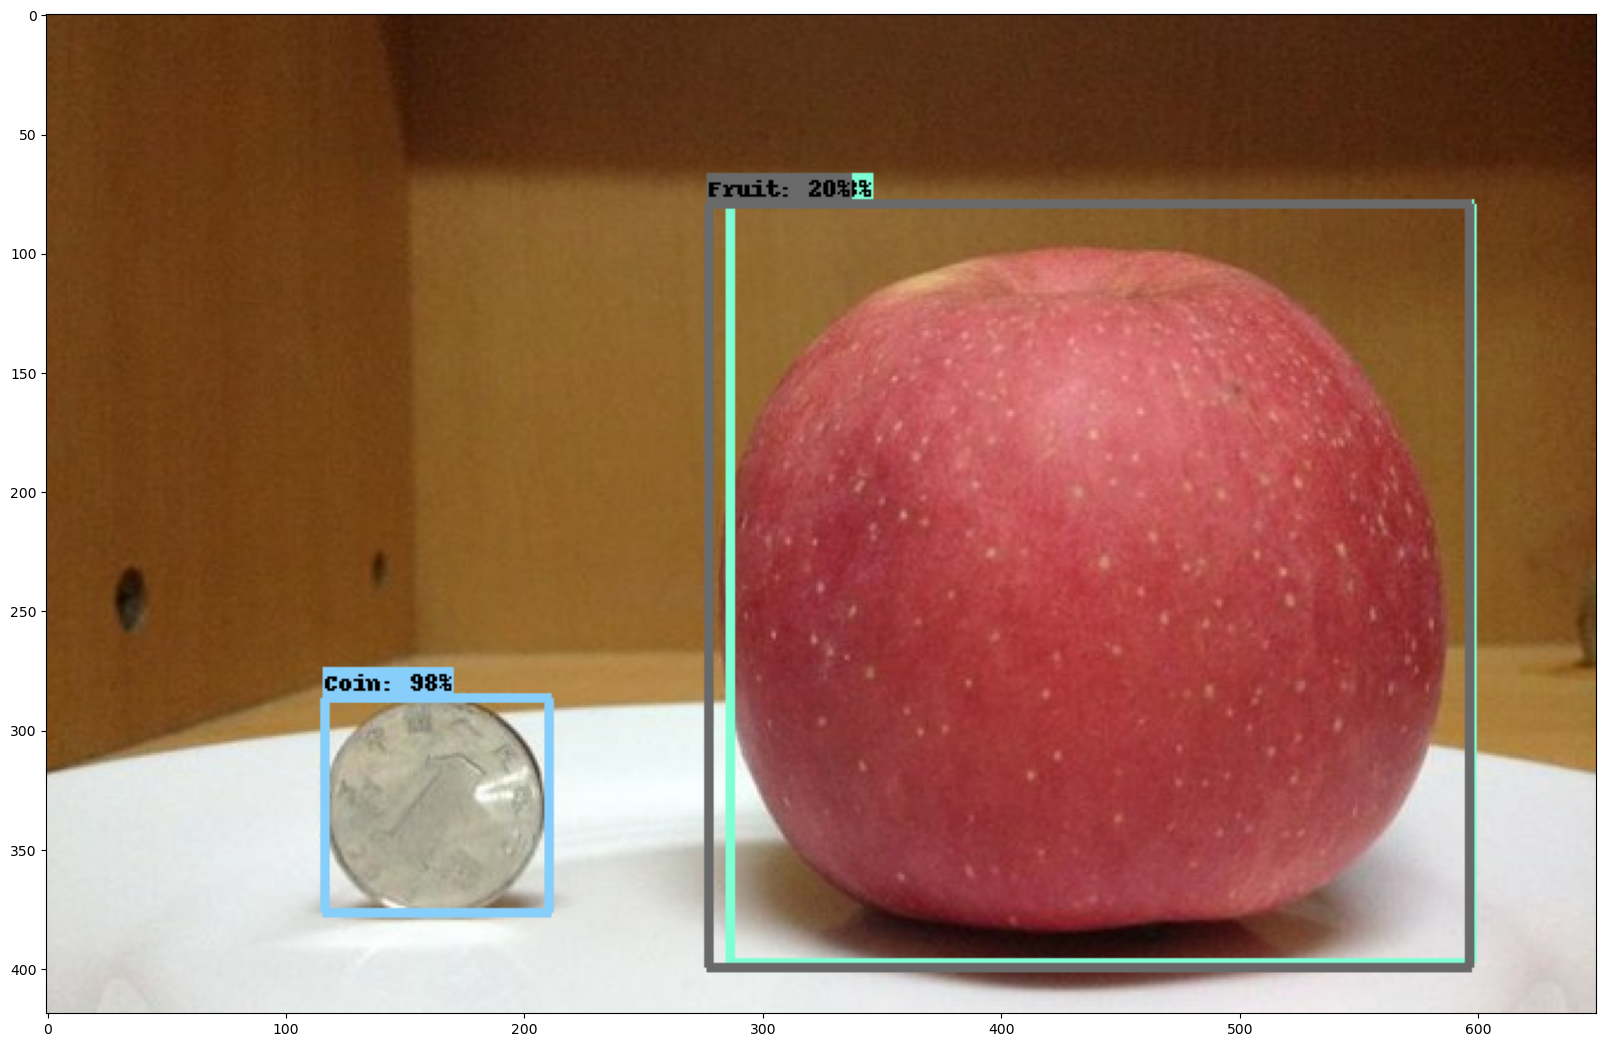

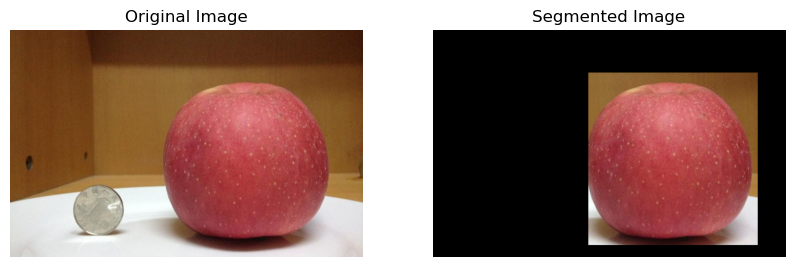

0.26457826224997355
0.26457826224997355
Estimated dimensions of the food box from the top view (length x height) 82.54841782199175 mm x 83.87130913324161 mm
Estimated dimensions of the food box from the side view (length x height) 66.9383003492433 mm x 64.29251772674357 mm
Estimated weight: 347.1979974191845 g
Estimated volume: 445.1256377169032 cm^3
Estimated calories: 180.54295865797596 calories
0


In [12]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

class ImageWindow:
    def __init__(self, root):
        self.root = root
        self.img1_tk = None
        self.img2_tk = None

    def load_images_and_process(self):
        image_path = filedialog.askopenfilename()
        image_path1 = filedialog.askopenfilename()

        if image_path and image_path1:
            self.display_images(image_path, image_path1)
            print("Avvio del processo...")
            weight_string, volume_string, calories_string = process_images(image_path, image_path1)
            label_text = tk.Label(root, text= weight_string + volume_string + calories_string)
            label_text.config(text=weight_string + volume_string + calories_string)
            label_text.pack()

    def display_images(self, image_path1, image_path2):
        img1 = Image.open(image_path1)
        img2 = Image.open(image_path2)

        img1 = img1.resize((200, 200), Image.ANTIALIAS)
        img2 = img2.resize((200, 200), Image.ANTIALIAS)

        self.img1_tk = ImageTk.PhotoImage(img1)
        self.img2_tk = ImageTk.PhotoImage(img2)

        self.image_frame = tk.Toplevel(self.root)
        label1 = tk.Label(self.image_frame, image=self.img1_tk)
        label2 = tk.Label(self.image_frame, image=self.img2_tk)
        label1.pack(side=tk.LEFT)
        label2.pack(side=tk.RIGHT)

root = tk.Tk()
root.title("Elaborazione di Immagini")
root.geometry("500x300")  

image_window = ImageWindow(root)

load_button = tk.Button(root, text="Carica Immagini", command=image_window.load_images_and_process)
load_button.pack()

root.mainloop()
